### Deep Convolutional Generative Adversarial Networks (DCGAN)

[original paper](https://arxiv.org/abs/1511.06434) <br>
[keras example reference](https://keras.io/examples/generative/dcgan_overriding_train_step/)

#### Datasets:
[Celeb-a kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset)
[Google cartoon](https://google.github.io/cartoonset/download.html)

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

# configure the GPU
physical_devices = tf.config.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\vedan\AppData\Local\Programs\Python\Python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
square_dims = 64
latent_size = int(square_dims/8)
latent_dim = 128

In [3]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(square_dims, square_dims, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 flatten (Flatten)           (None, 32768)           

#### Conv2DTranspose -> Reverse Convolution
* upscaler
* used in encoder and decoder architecture as decompressor

In [4]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(latent_size * latent_size * 128),
        layers.Reshape((latent_size, latent_size, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()


Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_1 (Dense)             (None, 32768)             4227072   
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 32, 32, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 64, 64, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 64, 64, 256)       0 

In [3]:
from tqdm import tqdm

In [4]:
opt_gen = keras.optimizers.Adam(1e-4)
opt_disc = keras.optimizers.Adam(1e-4)
loss_fn = keras.losses.BinaryCrossentropy()

In [5]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }


In [6]:
epoch_offset = 332
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        epoch+=epoch_offset

        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(f"./generated/generated_img_{epoch}_{i}.png")

        # save the models
        self.model.generator.save(f"./models/DCGAN/generator/generator_{epoch}")
        self.model.discriminator.save(f"./models/DCGAN/dis/discriminator_{epoch}")

In [7]:
generator = keras.models.load_model("./models/DCGAN/generator/generator_332")
discriminator = keras.models.load_model("./models/DCGAN/dis/discriminator_332")

In [8]:
dataset = keras.preprocessing.image_dataset_from_directory(
    directory="./dataset/cartoonset100k",
    labels=None,
    image_size=(square_dims, square_dims),
    batch_size=32,
    shuffle=True,
    color_mode="rgb",
).take(314).map(lambda x: x/255)

Found 100000 files belonging to 1 classes.


In [9]:
len(dataset)

314

In [11]:
epochs = 400  # In practice, use ~100 epochs

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)


Epoch 1/200
 24/314 [=>............................] - ETA: 1:01 - d_loss: 0.3183 - g_loss: 4.9524

In [5]:
generator = keras.models.load_model("./models/DCGAN/generator/generator_232")

In [ ]:
dataset.take(10000)

In [23]:
def upscale_image(image, factor=2):
    image = tf.image.resize(image, (image.shape[0] * factor, image.shape[1] * factor))
    # image = image / 255
    return image

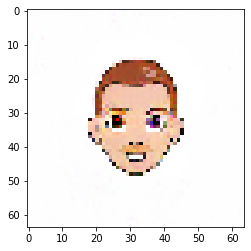

In [165]:
latent_dim = 128
random_vector = tf.random.normal(shape=(5, latent_dim))
output = generator(random_vector)[0]
# output = upscale_image(output)
plt.imshow(output)